# Boilerplate

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.precision', 2)
pd.set_option('display.float_format',  '{:,.2f}'.format)

In [3]:
# kpi_raw = pd.read_csv('../data/CSU_KPI_raw_2022-01-01_2025-01-15.csv')
kpi_raw = pd.read_csv('../data/CSU_KPI_raw_2022-01-01_2025-02-07.csv')

tiktok_raw = pd.read_csv('../data/CSU_data_tiktok_raw_2024-01-15.csv')
meta_raw = pd.read_csv('../data/CSU_data_meta_raw_2024-01-15.csv')
google_raw = pd.read_csv('../data/CSU_data_google_raw_2024-01-15.csv')
bing_raw = pd.read_csv('../data/CSU_data_bing_raw_2024-01-15.csv')
ttd_raw = pd.read_csv('../data/CSU_data_TTD_raw_2024-01-15.csv')
linkedin_raw = pd.read_csv('../data/CSU_data_linkedin_raw_2024-01-15.csv')

rev_map_raw = pd.read_excel('../data/Average revenue per application per week.xlsx')

# Process KPIs

## wrangle KPIs

In [116]:
# list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'GREENWOOD-GREENVILLE', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM (ANN AND TUSC)']
list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM (ANN AND TUSC)']

df_kpi_full = kpi_raw.copy()
df_kpi_full['leaddate'] = pd.to_datetime(df_kpi_full['leaddate']).dt.normalize()
df_kpi_full['appdate'] = pd.to_datetime(df_kpi_full['appdate']).dt.normalize()
df_kpi_full['enrolldate'] = pd.to_datetime(df_kpi_full['enrolldate']).dt.normalize()

df_kpi_full['model'] = None
df_kpi_full.loc[df_kpi_full['dmaname'].str.match('|'.join(list_awareness), na=False), 'model'] = 'awareness'
df_kpi_full.loc[df_kpi_full['dmaname'].str.contains('MOBILE-PENSACOLA', na=False), 'model'] = 'mobile'
df_kpi_full.loc[df_kpi_full['model'].isna(), 'model'] = 'national'
df_kpi_full = df_kpi_full.loc[df_kpi_full['leaddate'] < pd.Timestamp.today()].drop(['dmaname'], axis=1) 

df_kpi_full['channel'] = None
df_kpi_full.loc[df_kpi_full['dw_channel'].str.contains('PPL'), 'channel'] = 'PPL'
df_kpi_full.loc[df_kpi_full['channel'].isna(), 'channel'] = 'ALL(No PPL,Referral)' #NO PPL BUT Everything else
df_kpi_full = df_kpi_full.loc[df_kpi_full.leaddate < '2025-01-10'] ##keeping with saturday-friday

df_kpi_cohort = df_kpi_full.loc[df_kpi_full.model != 'mobile'].copy()
df_kpi_cohort = df_kpi_cohort.loc[df_kpi_full.channel != 'PPL'].copy()

df_kpi_cohort = df_kpi_cohort[['leaddate','n_lead','n_app','model']].reset_index(drop=True)

df_kpi_cohort = df_kpi_cohort.groupby(['leaddate','model']).agg(n_app=('n_app','sum'), n_lead=('n_lead','sum'))
df_kpi_daily = df_kpi_cohort.unstack('model').fillna(0)
df_kpi_weekly = df_kpi_daily.resample('W-Sat').sum()
df_kpi_weekly.index.name='date'
# df_kpi_weekly = df_kpi_weekly.droplevel(0, axis=1)
# df_kpi_weekly = df_kpi_weekly.reset_index(drop=False)
# df_kpi_weekly = df_kpi_weekly.rename(columns={'leaddate':'date'})

model_name, model_kpi = 'awareness', 'n_lead'

dict_models = {}
dict_models[model_name] = df_kpi_weekly[(model_kpi, model_name)].copy()
dict_models[model_name] = pd.DataFrame(dict_models[model_name]) 
dict_models[model_name].columns = [model_kpi]
dict_models[model_name] = dict_models[model_name].reset_index(drop=False)

# dict_models['awareness'] = dict_models['awareness'].rename(columns={'awareness':'n_app'})
# dict_models['awareness'].columns.name=None

model_name, model_kpi = 'national', 'n_app'

dict_models[model_name] = df_kpi_weekly[(model_kpi, model_name)].copy()
dict_models[model_name] = pd.DataFrame(dict_models[model_name]) 
dict_models[model_name].columns = [model_kpi]
dict_models[model_name] = dict_models[model_name].reset_index(drop=False)

## Investigate lead to app 

In [148]:
df_perc = df_kpi_full.loc[df_kpi_full.model=='awareness', ['n_lead','n_app']].sum()
lead2app_awareness = df_perc['n_app']/df_perc['n_lead']

lag_hist = np.round(df_kpi_daily[('n_lead','awareness')].sub(df_kpi_daily[('n_app','awareness')]).values/7)
df_hist = pd.DataFrame({'n_wk': lag_hist})

array([[<Axes: title={'center': 'n_wk'}>]], dtype=object)

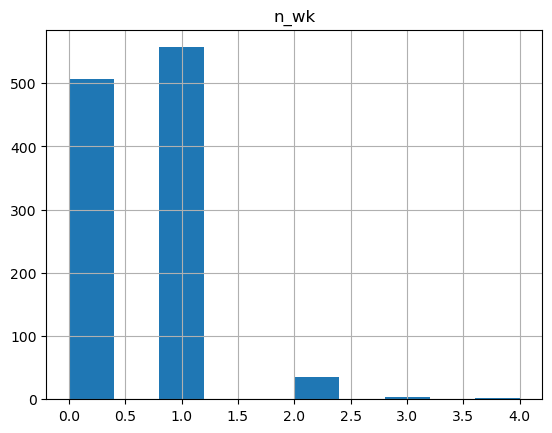

In [150]:
df_hist.hist()

In [ ]:
# Ok, no real lag, so I'm not lagging the revenue further, just scaling down from app to leads.

In [151]:
lead2app_awareness

0.22142372881355932

In [154]:
rev_map_app = rev_map_raw[[2023]].copy()
rev_map_app = rev_map_app[~rev_map_app[2023].isna()]
rev_map_lead = rev_map_app.mul(lead2app_awareness)

In [161]:
dict_models['awareness']

,date,n_lead
0,2022-01-01,0.00
1,2022-01-08,20.00
2,2022-01-15,34.00
3,2022-01-22,31.00
4,2022-01-29,34.00
...,...,...
154,2024-12-14,59.00
155,2024-12-21,51.00
156,2024-12-28,54.00
157,2025-01-04,56.00


In [166]:
kernel_app = rev_map_app.values.flatten() #len = 52
kernel_lead = rev_map_lead.values.flatten() #len = 52

x_val_awareness = np.array(dict_models['awareness']['n_lead'].values) #len = 159
x_val_national = np.array(dict_models['national']['n_app'].values) #len = 159

revenue_app_aware = np.convolve(x_val_a, kernel_lead, mode='same')

In [178]:
x_val_national

array([ 15., 186., 195., 208., 215., 185., 184., 187., 167., 146., 172.,
       182., 145., 172., 177., 161., 152., 186., 175., 177., 169., 169.,
       156., 150., 173., 154., 174., 174., 195., 187., 186., 187., 185.,
       220., 212., 170., 173., 166., 180., 142., 163., 135., 183., 188.,
       162., 185., 167., 103., 157., 179., 193., 133., 127., 248., 319.,
       319., 354., 334., 286., 265., 244., 299., 317., 271., 358., 262.,
       235., 277., 265., 301., 296., 299., 316., 285., 256., 303., 297.,
       288., 299., 214., 281., 303., 358., 312., 377., 327., 344., 336.,
       247., 340., 295., 344., 207., 244., 294., 294., 257., 311., 296.,
       168., 294., 255., 266., 232., 210., 238., 301., 275., 285., 303.,
       245., 245., 277., 305., 268., 218., 315., 254., 252., 275., 449.,
       289., 297., 321., 341., 281., 258., 271., 259., 295., 276., 224.,
       300., 311., 332., 310., 324., 291., 314., 276., 244., 239., 251.,
       241., 218., 190., 242., 239., 223., 285., 25

In [179]:
kernel_app

array([ 0.294394,  3.691986,  9.650219, 16.641804, 24.975806, 32.94221 ,
       35.600198, 34.971241, 30.611367, 24.572852, 24.899847, 24.157337,
       26.070872, 31.462738, 38.157705, 36.705655, 40.954153, 38.866414,
       30.180865, 29.089487, 26.101259, 26.398611, 29.386438, 34.679509,
       36.379112, 40.484554, 38.400775, 35.725115, 31.162839, 26.279154,
       23.568867, 26.014152, 29.950694, 34.583563, 40.421887, 38.738536,
       35.794609, 33.121956, 28.367263, 23.192897, 24.486925, 24.946243,
       30.709768, 37.485607, 37.302613, 32.473372, 32.83107 , 27.955761,
       23.369885, 23.738781, 24.448994, 27.387037])

In [329]:
# def create_shifted_array(arr, shifts, n_pad=None):
def create_shifted_array(arr_in, n_size):
    """
    Creates an array containing shifted versions of the input array.

    Args:
        arr (numpy.ndarray): The input array.
        shifts (list of int): A list of integers representing the shift amounts.
        n_pad (int): how

    Returns:
        numpy.ndarray: An array where each row is a shifted version of the input array.
    """
    arr_in = arr_in.reshape(-1)
    arr = np.zeros(n_size)
    arr[:len(arr_in)] = arr_in
    arr_out = np.zeros((n_size, n_size))
    shifts = np.arange(n_size)
    for shift in shifts:
        tmp = np.roll(arr, shift)
        tmp[:shift] = 0
        arr_out[:, shift] = tmp
        #     rows.append(tmp)
    return arr_out

def calc_conv(k, v):
    k = np.array(k)
    v_out = np.array(v)
    v_out = v_out.reshape(-1)
    k_mat = create_shifted_array(k, len(v))
    conv = np.sum(k_mat*v_out, -1)
    return conv

In [335]:
rev_nat = calc_conv(kernel_app, x_val_national)
rev_aw = calc_conv(kernel_lead, x_val_awareness)

In [373]:
dict_models['national']['date']

0     2022-01-01
1     2022-01-08
2     2022-01-15
3     2022-01-22
4     2022-01-29
         ...    
154   2024-12-14
155   2024-12-21
156   2024-12-28
157   2025-01-04
158   2025-01-11
Name: date, Length: 159, dtype: datetime64[ns]

In [378]:
df_national_rev = pd.DataFrame({'date': dict_models['national']['date'], 'revenue': rev_nat})
df_awareness_rev = pd.DataFrame({'date': dict_models['awareness']['date'], 'revenue': rev_aw})

In [379]:
df_national_rev.to_csv('../data/national_revenue_2025-02-07.csv')
df__rev.to_csv('../data/national_revenue_2025-02-07.csv')

,date,revenue
0,2022-01-01,4.42
1,2022-01-08,110.14
2,2022-01-15,888.87
3,2022-01-22,"2,825.74"
4,2022-01-29,"6,183.03"
...,...,...
154,2024-12-14,"417,521.13"
155,2024-12-21,"417,879.27"
156,2024-12-28,"418,518.25"
157,2025-01-04,"417,772.01"


In [380]:
df_awareness_rev

,date,revenue
0,2022-01-01,0.00
1,2022-01-08,1.30
2,2022-01-15,18.57
3,2022-01-22,72.55
4,2022-01-29,173.91
...,...,...
154,2024-12-14,"17,968.34"
155,2024-12-21,"18,151.65"
156,2024-12-28,"18,269.34"
157,2025-01-04,"18,281.74"


In [371]:
rev_aw

array([0.00000000e+00, 1.30371634e+00, 1.85661839e+01, 7.25512823e+01,
       1.73907190e+02, 3.32077308e+02, 5.49075135e+02, 7.91069574e+02,
       1.02653829e+03, 1.23786500e+03, 1.40391043e+03, 1.55030080e+03,
       1.69746127e+03, 1.84452473e+03, 2.02067058e+03, 2.23638311e+03,
       2.44251756e+03, 2.67389431e+03, 2.92538730e+03, 3.13415250e+03,
       3.32998249e+03, 3.52049971e+03, 3.68490345e+03, 3.86073819e+03,
       4.06204085e+03, 4.24218326e+03, 4.44575699e+03, 4.62135985e+03,
       4.80305769e+03, 4.99723118e+03, 5.15233594e+03, 5.29723459e+03,
       5.46301514e+03, 5.61691519e+03, 5.79317398e+03, 6.03609478e+03,
       6.22538220e+03, 6.44791922e+03, 6.64587663e+03, 6.81709536e+03,
       6.97101490e+03, 7.11392547e+03, 7.21157548e+03, 7.30565895e+03,
       7.45097704e+03, 7.56670032e+03, 7.72362424e+03, 7.89400603e+03,
       8.03658177e+03, 8.17336832e+03, 8.29833550e+03, 8.42081486e+03,
       8.52569554e+03, 8.48685074e+03, 8.34784317e+03, 8.26456362e+03,
      

### Scrap checking

In [368]:
np.sum(np.flip(kernel_lead)*x_val_awareness[-53:-1],-1)

18281.74345720393

In [338]:
rev_nat[-3:]

array([418518.247794, 417772.005373, 414581.565447])

In [337]:
rev_aw

array([0.00000000e+00, 1.30371634e+00, 1.85661839e+01, 7.25512823e+01,
       1.73907190e+02, 3.32077308e+02, 5.49075135e+02, 7.91069574e+02,
       1.02653829e+03, 1.23786500e+03, 1.40391043e+03, 1.55030080e+03,
       1.69746127e+03, 1.84452473e+03, 2.02067058e+03, 2.23638311e+03,
       2.44251756e+03, 2.67389431e+03, 2.92538730e+03, 3.13415250e+03,
       3.32998249e+03, 3.52049971e+03, 3.68490345e+03, 3.86073819e+03,
       4.06204085e+03, 4.24218326e+03, 4.44575699e+03, 4.62135985e+03,
       4.80305769e+03, 4.99723118e+03, 5.15233594e+03, 5.29723459e+03,
       5.46301514e+03, 5.61691519e+03, 5.79317398e+03, 6.03609478e+03,
       6.22538220e+03, 6.44791922e+03, 6.64587663e+03, 6.81709536e+03,
       6.97101490e+03, 7.11392547e+03, 7.21157548e+03, 7.30565895e+03,
       7.45097704e+03, 7.56670032e+03, 7.72362424e+03, 7.89400603e+03,
       8.03658177e+03, 8.17336832e+03, 8.29833550e+03, 8.42081486e+03,
       8.52569554e+03, 8.48685074e+03, 8.34784317e+03, 8.26456362e+03,
      

## Bunch of scrap

In [327]:
k = np.array([1,3,7,9,4,2])
v = np.array([2,6,3,5,8,8,9,3,4,1])

# k_mat = create_shifted_array(k, len(v))
# conv = np.sum(k_mat*v, axis=1)

In [330]:
calc_conv(k, v)

array([  2.,  12.,  35.,  74., 106., 122., 158., 184., 190., 163.])

In [320]:
k_mat*v_out

array([[ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 6.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [14., 18.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [18., 42.,  9.,  5.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 8., 54., 21., 15.,  8.,  0.,  0.,  0.,  0.,  0.],
       [ 4., 24., 27., 35., 24.,  8.,  0.,  0.,  0.,  0.],
       [ 0., 12., 12., 45., 56., 24.,  9.,  0.,  0.,  0.],
       [ 0.,  0.,  6., 20., 72., 56., 27.,  3.,  0.,  0.],
       [ 0.,  0.,  0., 10., 32., 72., 63.,  9.,  4.,  0.],
       [ 0.,  0.,  0.,  0., 16., 32., 81., 21., 12.,  1.]])

In [319]:
np.sum(k_mat*v_out, -1)

array([  2.,  12.,  35.,  74., 106., 122., 158., 184., 190., 163.])

In [317]:
v_out

array([2, 6, 3, 5, 8, 8, 9, 3, 4, 1])

In [306]:
k.reshape(-1)

array([1, 3, 7, 9, 4, 2])

In [302]:
k_mat

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [3., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [7., 3., 1., 0., 0., 0., 0., 0., 0., 0.],
       [9., 7., 3., 1., 0., 0., 0., 0., 0., 0.],
       [4., 9., 7., 3., 1., 0., 0., 0., 0., 0.],
       [2., 4., 9., 7., 3., 1., 0., 0., 0., 0.],
       [0., 2., 4., 9., 7., 3., 1., 0., 0., 0.],
       [0., 0., 2., 4., 9., 7., 3., 1., 0., 0.],
       [0., 0., 0., 2., 4., 9., 7., 3., 1., 0.],
       [0., 0., 0., 0., 2., 4., 9., 7., 3., 1.]])

In [275]:
a = np.array([[3,2,1],[-1,0,4]])
b = np.array([[1],[4],[6]])

In [294]:
a

array([[ 3,  2,  1],
       [-1,  0,  4]])

In [295]:
b

array([[1],
       [4],
       [6]])

In [296]:
np.sum((a*b.reshape(-1)), -1)

array([17, 23])

In [287]:
c

array([[[ 3,  2,  1],
        [-1,  0,  4]],

       [[12,  8,  4],
        [-4,  0, 16]],

       [[18, 12,  6],
        [-6,  0, 24]]])

In [288]:
c.shape

(3, 2, 3)

In [267]:
v

[2, 6, 3, 5, 8, 8, 9, 3, 4, 1]

In [268]:
k_mat

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [3., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [7., 3., 1., 0., 0., 0., 0., 0., 0., 0.],
       [9., 7., 3., 1., 0., 0., 0., 0., 0., 0.],
       [4., 9., 7., 3., 1., 0., 0., 0., 0., 0.],
       [2., 4., 9., 7., 3., 1., 0., 0., 0., 0.],
       [0., 2., 4., 9., 7., 3., 1., 0., 0., 0.],
       [0., 0., 2., 4., 9., 7., 3., 1., 0., 0.],
       [0., 0., 0., 2., 4., 9., 7., 3., 1., 0.],
       [0., 0., 0., 0., 2., 4., 9., 7., 3., 1.]])

In [269]:
k_mat*v

array([[ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 6.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [14., 18.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [18., 42.,  9.,  5.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 8., 54., 21., 15.,  8.,  0.,  0.,  0.,  0.,  0.],
       [ 4., 24., 27., 35., 24.,  8.,  0.,  0.,  0.,  0.],
       [ 0., 12., 12., 45., 56., 24.,  9.,  0.,  0.,  0.],
       [ 0.,  0.,  6., 20., 72., 56., 27.,  3.,  0.,  0.],
       [ 0.,  0.,  0., 10., 32., 72., 63.,  9.,  4.,  0.],
       [ 0.,  0.,  0.,  0., 16., 32., 81., 21., 12.,  1.]])

In [270]:
conv

array([  2.,  12.,  35.,  74., 106., 122., 158., 184., 190., 163.])

In [226]:
np.zeros(5)

array([0., 0., 0., 0., 0.])

In [220]:
k = np.array(kernel_app)
v = np.array(x_val_national)

t = len(v)

output = create_shifted_array(k, np.arange(t))

In [223]:
k

array([ 0.294394,  3.691986,  9.650219, 16.641804, 24.975806, 32.94221 ,
       35.600198, 34.971241, 30.611367, 24.572852, 24.899847, 24.157337,
       26.070872, 31.462738, 38.157705, 36.705655, 40.954153, 38.866414,
       30.180865, 29.089487, 26.101259, 26.398611, 29.386438, 34.679509,
       36.379112, 40.484554, 38.400775, 35.725115, 31.162839, 26.279154,
       23.568867, 26.014152, 29.950694, 34.583563, 40.421887, 38.738536,
       35.794609, 33.121956, 28.367263, 23.192897, 24.486925, 24.946243,
       30.709768, 37.485607, 37.302613, 32.473372, 32.83107 , 27.955761,
       23.369885, 23.738781, 24.448994, 27.387037])

In [225]:
output[8,:]

array([ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.294394,  3.691986,  9.650219, 16.641804,
       24.975806, 32.94221 , 35.600198, 34.971241, 30.611367, 24.572852,
       24.899847, 24.157337, 26.070872, 31.462738, 38.157705, 36.705655,
       40.954153, 38.866414, 30.180865, 29.089487, 26.101259, 26.398611,
       29.386438, 34.679509, 36.379112, 40.484554, 38.400775, 35.725115,
       31.162839, 26.279154, 23.568867, 26.014152, 29.950694, 34.583563,
       40.421887, 38.738536, 35.794609, 33.121956, 28.367263, 23.192897,
       24.486925, 24.946243, 30.709768, 37.485607])

In [196]:
v = np.array(x_val_national)
k = np.array(kernel_app)

ii = 25
val = np.min(ii, len(k))

k_tmp = k[:val]
v_tmp = np.flip(v[ii- :ii])

In [195]:
np.mul(k[:val], v[

array([ 0.294394,  3.691986,  9.650219, 16.641804, 24.975806, 32.94221 ,
       35.600198, 34.971241, 30.611367, 24.572852, 24.899847, 24.157337,
       26.070872, 31.462738, 38.157705, 36.705655, 40.954153, 38.866414,
       30.180865, 29.089487, 26.101259, 26.398611, 29.386438, 34.679509,
       36.379112, 40.484554, 38.400775, 35.725115, 31.162839, 26.279154,
       23.568867, 26.014152, 29.950694, 34.583563, 40.421887, 38.738536,
       35.794609, 33.121956, 28.367263, 23.192897, 24.486925, 24.946243,
       30.709768, 37.485607, 37.302613, 32.473372, 32.83107 , 27.955761,
       23.369885, 23.738781, 24.448994, 27.387037])

In [192]:
v = np.array(x_val_national)
k = np.array(kernel_app)

n_time = len(v)
n_kernel = len(k)


dummy = [0]*n_time

for ii in np.arange(n_time):
    for jj in np.arange(np.max(0, ii-jj))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [175]:
np.convolve(kernel_lead, x_val_awareness, mode='same')[:10]

array([4242.18326149, 4445.75699413, 4621.35985227, 4803.05768884,
       4997.23117776, 5152.33593682, 5297.23458648, 5463.0151396 ,
       5616.91519304, 5793.17397691])

In [176]:
x_val_awareness[:10]

array([ 0., 20., 34., 31., 34., 33., 20., 28., 35., 31.])

In [177]:
kernel_lead

array([0.06518582, 0.81749331, 2.13678747, 3.6848903 , 5.53023609,
       7.29418697, 7.88272859, 7.74346258, 6.77808303, 5.44101252,
       5.51341697, 5.34900764, 5.77270969, 6.96659677, 8.44902132,
       8.127503  , 9.06822127, 8.60594631, 6.68275967, 6.44110268,
       5.77943809, 5.84527888, 6.50685468, 7.6788662 , 8.05519863,
       8.96424091, 8.50284279, 7.91038818, 6.90019201, 5.81882827,
       5.21870642, 5.76015054, 6.63179435, 7.65762148, 8.95036495,
       8.57763109, 7.9257758 , 7.333987  , 6.28118515, 5.13545774,
       5.42198624, 5.52369014, 6.79987134, 8.30020288, 8.25968366,
       7.19037512, 7.26957794, 6.19006884, 5.17464708, 5.25632941,
       5.41358742, 6.06413985])

In [ ]:
### convolution
kernel = rev_map.values.flatten() #len = 52
x_val_a = np.array(df_kpi_cohort_weekly_aware['n_app'].values) #len = 159
revenue_app_aware = np.convolve(x_val_a, kernel, mode='same')

df_kpi_cohort_weekly_aware['revenue_app'] = revenue_app_aware
df_kpi_cohort_weekly_aware['revenue_lead'] = revenue_app_aware * l2a_aware_conv

kernel = rev_map.values.flatten() #len = 52
x_val_n = np.array(df_kpi_cohort_weekly_national['n_app'].values) #len = 159
revenue_app_national = np.convolve(x_val_n, kernel, mode='same')

df_kpi_cohort_weekly_national['revenue_app'] = revenue_app_national
df_kpi_cohort_weekly_national['revenue_lead'] = revenue_app_national * l2a_national_conv

# Wrangle media